In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../../etc/ignition_elevation_data.csv')

elevation_features = ['ignition_elev', 'mean_elev', 'min_elev', 'max_elev', 'std_elev', 'range_elev']
features = [f for f in elevation_features if f in df.columns]

if 'land_cover' in df.columns:
    lc_dummies = pd.get_dummies(df['land_cover'], prefix='lc')
    df = pd.concat([df, lc_dummies], axis=1)
    features.extend(lc_dummies.columns.tolist())

X = df[features]
y = df['fsr_km2_dy'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    # 'SVR': SVR(kernel='rbf'),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}

In [5]:
results = {}

for name, model in models.items():
    print(f"Training {name}...")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    results[name] = {
        'model': model,
        'mse': mse,
        'r2': r2,
        'predictions': y_pred
    }

    print(f"  MSE: {mse:.4f}")
    print(f"  R²: {r2:.4f}")
    print("-" * 30)

Training Linear Regression...
  MSE: 1.8358
  R²: 0.0167
------------------------------
Training Ridge Regression...
  MSE: 1.8357
  R²: 0.0167
------------------------------
Training Lasso Regression...
  MSE: 1.8648
  R²: 0.0011
------------------------------
Training Random Forest...
  MSE: 1.9329
  R²: -0.0354
------------------------------
Training Gradient Boosting...
  MSE: 1.8243
  R²: 0.0228
------------------------------
Training Neural Network...
  MSE: 148.1403
  R²: -78.3536
------------------------------


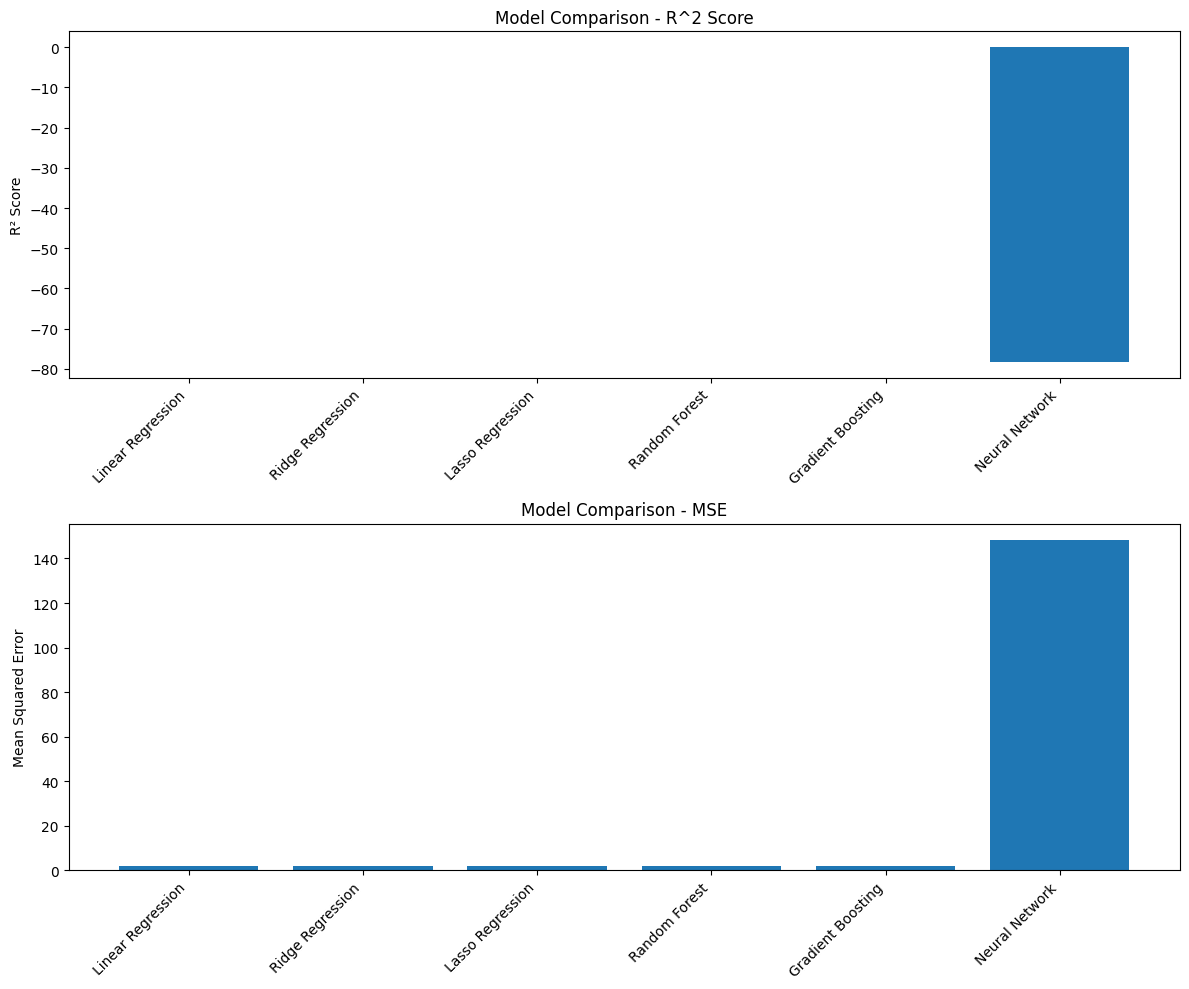

Best model based on R^2 score: Gradient Boosting


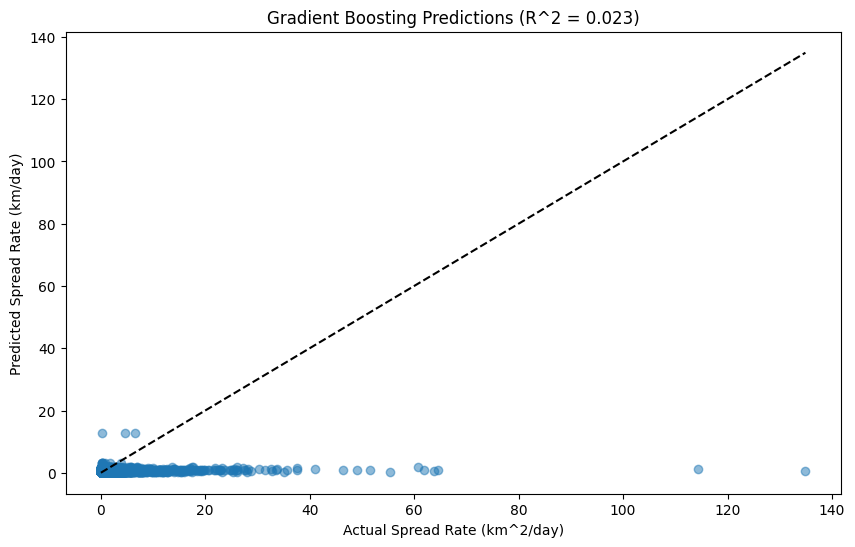

In [6]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
model_names = list(results.keys())
r2_scores = [results[name]['r2'] for name in model_names]
plt.bar(model_names, r2_scores)
plt.ylabel('R² Score')
plt.title('Model Comparison - R^2 Score')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 1, 2)
mse_scores = [results[name]['mse'] for name in model_names]
plt.bar(model_names, mse_scores)
plt.ylabel('Mean Squared Error')
plt.title('Model Comparison - MSE')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

best_model_name = model_names[np.argmax(r2_scores)]
print(f"Best model based on R^2 score: {best_model_name}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, results[best_model_name]['predictions'], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual Spread Rate (km^2/day)')
plt.ylabel('Predicted Spread Rate (km/day)')
plt.title(f'{best_model_name} Predictions (R^2 = {results[best_model_name]["r2"]:.3f})')
plt.show()